# Access CELLxGENE-hosted embeddings

This notebook demonstrates basic access to CELLxGENE-hosted embeddings of the Census. **CELLxGENE-hosted embeddings have been contributed by the community**, CELLxGENE Discover does not actively maintain or update them. Find out more about these in the [Census model page](https://cellxgene.cziscience.com/census-models). 

**IMPORTANT:** This tutorial requires cellxgene-census package version 1.9.1 or later.

## Contents

1. Background
2. Quick start
3. Query cells and load associated embeddings
4. Load embeddings and fetch associated Census data
5. Embedding metadata

> ⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable `is_primary_data` which is described in the [Census schema](https://github.com/chanzuckerberg/cellxgene-census/blob/main/docs/cellxgene_census_schema.md#repeated-data).


## Background

This notebook demonstrates access to CELLxGENE-hosted embeddings of the Census. The Census has multiple releases, named by a `census_version`, which normally looks like an ISO date, e.g., `2023-02-01`. A CELLxGENE-hosted embedding is a 2D sparse matrix of cell embeddings _for a given census version_, encoded as a SOMA SparseNDArray.

⚠️ Note that embeddings may be available for one or both organisms, see the [Census model page](https://cellxgene.cziscience.com/census-models) for the latest availability.

⚠️ **IMPORTANT:** embeddings are only meaningful in the context of the Census from which they were created. Each embedding contains a metadata field indicating the source Census, suitable for confirming embedding lineage.

## Quick start

The easiest way to access Census CELLxGENE-hosted embeddings is by calling the `get_anndata` function with an `obs_embeddings` or `var_embeddings` parameter.

Let's start by exploring what embeddings are available:

In [1]:
from cellxgene_census.experimental import get_all_available_embeddings

In [2]:
CENSUS_VERSION = "2023-12-15"

In [3]:
for e in get_all_available_embeddings(CENSUS_VERSION):
    print(f"{e['embedding_name']:15} {e['experiment_name']:15} {e['data_type']:15}")

scvi            mus_musculus    obs_embedding  
scvi            homo_sapiens    obs_embedding  
geneformer      homo_sapiens    obs_embedding  
scgpt           homo_sapiens    obs_embedding  
uce             homo_sapiens    obs_embedding  
uce             mus_musculus    obs_embedding  
nmf             homo_sapiens    obs_embedding  
nmf             homo_sapiens    var_embedding  


These can also be viewed on the [CELLxGENE Census Models page](https://cellxgene.cziscience.com/census-models). 

For this example, we'll use `scgpt`. We can call `get_anndata` with the `obs_embeddings` parameter:

In [4]:
import cellxgene_census

In [5]:
from cellxgene_census.experimental import get_embedding

In [6]:
CENSUS_VERSION = "2023-12-15"

In [7]:
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    adata = cellxgene_census.get_anndata(
        census,
        organism="homo_sapiens",
        measurement_name="RNA",
        obs_value_filter="tissue == 'tongue'",
        obs_embeddings=["scgpt"],
    )

And now you can use these data for downstream analysis.

In [9]:
adata

AnnData object with n_obs × n_vars = 372 × 60664
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scgpt'

In [10]:
adata.obsm

AxisArrays with keys: scgpt

⚠️ **IMPORTANT**: `get_embedding` will fill in missing values in the embedding matrix with `NaN`, therefore missing cells are represented with rows where all values are `NaN`. To learn more use `help(get_embedding)`.

## Storage format

Each embedding is encoded as a SOMA SparseNDArray, where:

* dimension 0 (`soma_dim_0`) encodes the cell (obs) `soma_joinid` value
* dimension 1 (`soma_dim_1`) encodes the embedding feature, and is in the range [0, N) where N is the number of featues in the embedding
* data (`soma_data`) is float32

⚠️ **IMPORTANT:** CELLxGENE-hosted embeddings may embed a subset of the cells in any given Census version. If a cell has an embedding, it will be explicitly stored in the sparse array, _even if the embedding value is zero_. In other words, missing array values values imply that the cell was not embedded, whereas zero valued embeddings are explicitly stored. Put another way, the `nnz` of the embedding array indicate the number of embedded cells, not the number of non-zero values.

The first axis of the embedding array will have the same shape as the corresponding `obs` DataFrame for the Census build and experiment. The second axis of the embedding will have a shape (0, N) where N is the number of features in the embedding.

Embedding values, while stored as a float32, are precision reduced. Currently they are equivalent to a bfloat16, i.e., have 8 bits of exponent and 7 bits of mantissa.


## Query cells and load associated embeddings

This section demonstrates two methods to query cells from the Census by `obs` metadata, and then fetch CELLxGENE-hosted embeddings associated with each cell.

1. Load an embedding into an AnnData `obsm` slot
2. Load an embedding into a dense NumPy array

Let's first do a few imports and utility functions used throughout this notebook.

In [11]:
import warnings

In [12]:
warnings.filterwarnings("ignore")

In [13]:
from cellxgene_census.experimental import get_embedding_metadata

In [14]:
import tiledbsoma as soma

In [15]:
import numpy as np

In [16]:
import scanpy

In [17]:
# The Census version to utilize
CENSUS_VERSION = "2023-12-15"
EXPERIMENT_NAME = "homo_sapiens"
MEASUREMENT_NAME = "RNA"

In [18]:
# The location of the embedding.  See <https://cellxgene.cziscience.com/census-models>
# for available CELLxGENE-hosted embeddings.
EMBEDDING_URI = "s3://cellxgene-contrib-public/contrib/cell-census/soma/2023-12-15/CxG-contrib-1/"

### Load an embedding into an AnnData `obsm` slot

There are two main ways to load hosted embeddings into an AnnData.

1. Via `cellxgene_census.get_anndata()`, followed by merging embeddings.
2. With a lazy query via `ExperimentAxisQuery`, followed by merging embeddings.


#### AnnData embeddings via cellxgene_census.get_anndata()

This is the simplest way of getting the embeddings. In this example we create an AnnData for all "central nervous system" cells, and use the `obs_embeddings` parameter to add scGPT embeddings to the `obsm` slot.


In [19]:
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    adata = cellxgene_census.get_anndata(
        census,
        organism=EXPERIMENT_NAME,
        measurement_name=MEASUREMENT_NAME,
        obs_value_filter="tissue_general == 'central nervous system'",
        obs_column_names=["cell_type", "soma_joinid"],
        obs_embeddings=["scgpt"],
    )

In [20]:
adata

AnnData object with n_obs × n_vars = 31780 × 60664
    obs: 'cell_type', 'soma_joinid', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scgpt'

⚠️ **IMPORTANT**: `get_embedding` will fill in missing values in the embedding matrix with `NaN`, therefore missing cells are represented with rows where all values are `NaN`. To learn more use `help(get_embedding)`.

Then we can take a quick look at the embeddings in a 2D scatter plot via UMAP.

In [21]:
scanpy.pp.neighbors(adata, use_rep="scgpt")

In [22]:
scanpy.tl.umap(adata)

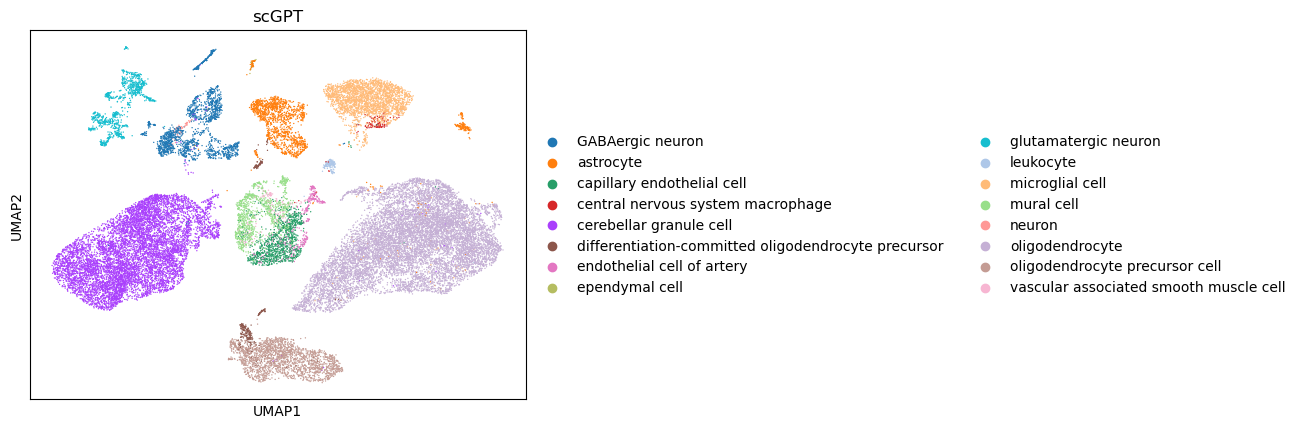

In [23]:
scanpy.pl.umap(adata, color="cell_type", title="scGPT")

#### AnnData embeddings via `ExperimentAxisQuery`

Using an `ExperimentAxisQuery` to get embeddings into an AnnData has the main advantage of inspecting the query in a lazy manner before loading all data into AnnData.

As a reminder this class offers a lazy interface to query Census based on cell and gene metadata, and provides access to the correspondong expression data, and cell/gene metadata.

Let's initiate a lazy query with the same filters as the previous example.

In [24]:
census = cellxgene_census.open_soma(census_version=CENSUS_VERSION)

In [25]:
experiment = census["census_data"][EXPERIMENT_NAME]

In [26]:
query = experiment.axis_query(
    measurement_name="RNA",
    obs_query=soma.AxisQuery(value_filter="tissue_general == 'central nervous system'"),
)

In [30]:
query

Now, before downloading all the data we can take a look at different attributes, for example the number of cells in our query.

In [31]:
query.n_obs

31780

And for example grab all the `soma_joinid` values for the cells in this query.

In [32]:
soma_joinids = query.obs_joinids().to_numpy()

Then create an AnnData.

In [33]:
adata = query.to_anndata(X_name="raw", column_names={"obs": ["cell_type"]})

In [34]:
adata

AnnData object with n_obs × n_vars = 31780 × 60664
    obs: 'cell_type', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

And finally add the embedding matrix via `get_embedding` for the cells of the query using the `soma_joinid` values.

In [35]:
adata.obsm["scgpt"] = get_embedding(
    census_version=CENSUS_VERSION,
    embedding_uri=EMBEDDING_URI,
    obs_soma_joinids=soma_joinids,
)

⚠️ **IMPORTANT**: `get_embedding` will fill in missing values in the embedding matrix with `NaN`, therefore missing cells are represented with rows where all values are `NaN`. To learn more use `help(get_embedding)`.

In [36]:
adata

AnnData object with n_obs × n_vars = 31780 × 60664
    obs: 'cell_type', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scgpt'

In [37]:
query.close()

In [38]:
census.close()

### Load an embedding into a dense NumPy array

To load a  embeddinng into a stand-alone numpy array you can select cells from the Census based on obs metadata, then given the resulting cells, use the `soma_joinid` values to download an embedding, and finally save as a dense NDArray.

Let's first select cells based on cell metadata

In [39]:
census = cellxgene_census.open_soma(census_version=CENSUS_VERSION)

In [40]:
obs_df = cellxgene_census.get_obs(
    census,
    EXPERIMENT_NAME,
    value_filter="tissue_general == 'exocrine gland'",
    column_names=["soma_joinid", "cell_type"],
)

In [41]:
obs_df.head()

,soma_joinid,cell_type,tissue_general
0,8281739,acinar cell of salivary gland,exocrine gland
1,8281740,acinar cell of salivary gland,exocrine gland
2,8281741,naive B cell,exocrine gland
3,8281742,memory B cell,exocrine gland
4,8281743,memory B cell,exocrine gland


Now you can use the `soma_joinid` values to download the corresponding rows of the embedding matrix via `get_embedding`.

In [42]:
embeddings = get_embedding(CENSUS_VERSION, EMBEDDING_URI, obs_df.soma_joinid.to_numpy())

In [43]:
embeddings[0:3, 0:4]

array([[-0.00506592, -0.01348877, -0.03173828, -0.02331543],
       [ 0.02404785, -0.02441406, -0.00595093, -0.0065918 ],
       [ 0.00070572,  0.00187683, -0.04663086, -0.04614258]],
      dtype=float32)

⚠️ **IMPORTANT**: `get_embedding` will fill in missing values in the embedding matrix with `NaN`, therefore missing cells are represented with rows where all values are `NaN`.  

In [44]:
embeddings.shape

(115722, 512)

## Load embeddings and fetch associated Census data

This section describes a more advanced use case. Here we showcase how to load large slices of an embeding matrix, and then append cell metadata to them.

The method starts with the loaded embedding, and for each embedded cell loads metadata or X data.

In [45]:
# Fetch first 500_000 joinids from the embedding.
# NOTE: will fail if the there are no cells embedded within this obs joinid range
embedding_slice = (slice(500_000),)

In [46]:
emb_data = []
emb_joinids = []

In [47]:
ctx = {"vfs.s3.region": "us-west-2", "vfs.s3.no_sign_request": True}

In [48]:
with soma.open(EMBEDDING_URI, context=soma.SOMATileDBContext(tiledb_config=ctx)) as E:
    # read embedding and obs joinids for each embedded cell
    for d, (obs_joinids, _) in (
        E.read(coords=embedding_slice).blockwise(axis=0, size=2**20, reindex_disable_on_axis=1).scipy()
    ):
        embedding_presence_mask = d.getnnz(axis=1) != 0
        emb_joinids.append(obs_joinids[embedding_presence_mask])
        emb_data.append(d[embedding_presence_mask, :].toarray())

    # concat
    embedding_data = np.vstack(emb_data)
    embedding_joinids = np.concatenate(emb_joinids)

In [49]:
# Load the associated metadata - in this case, obs.suspension_type
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    experiment = census["census_data"][EXPERIMENT_NAME]
    with experiment.axis_query(
        measurement_name=MEASUREMENT_NAME,
        obs_query=soma.AxisQuery(coords=(embedding_joinids,)),
    ) as query:
        obs_df = query.obs(column_names=["soma_joinid", "suspension_type"]).concat().to_pandas()

In [50]:
# Display the first few cells, and the first few columns of their embeddings
display(obs_df[0:3])

,soma_joinid,suspension_type
0,0,nucleus
1,1,nucleus
2,2,nucleus


In [51]:
display(embedding_data[0:3, 0:4])

array([[-0.00762939, -0.00076675, -0.00047874, -0.03588867],
       [ 0.00405884, -0.00239563,  0.00982666, -0.00946045],
       [ 0.00473022,  0.0135498 , -0.01049805, -0.03051758]],
      dtype=float32)

## Embedding Metadata

Each embedding contains descriptive information stored in the SOMA `metadata` slot, encoded as a JSON string. This metadata includes:

* census_version - the Census which is embedded. It is critical to confirm this matches the Census in use, or the embeddings will be meaningless.
* experiment_name - the Census experiment embedded, e.g., `homo_sapiens` or `mus_musculus`.
* measurement_name - the Census measurement embedded, e.g., `RNA`

There are a variety of other metadata values [documented here](https://github.com/chanzuckerberg/cellxgene-census/blob/main/tools/census_contrib/embedding_metadata.md).

The following example demonstrates how to access and decode the metadata into a Python dictionary.

In [52]:
embedding_metadata = get_embedding_metadata(EMBEDDING_URI)

In [53]:
embedding_metadata

{'id': 'CxG-contrib-1',
 'title': 'scGPT: Towards Building a Foundation Model for Single-Cell Multi-omics Using Generative AI',
 'description': 'Utilizing the burgeoning single-cell sequencing data, we have pioneered the construction of a foundation model for single-cell biology, scGPT, which is based on generative pre-trained transformer across a repository of over 33 million cells. Our findings illustrate that scGPT, a generative pre-trained transformer, effectively distills critical biological insights concerning genes and cells. Through the further adaptation of transfer learning, scGPT can be optimized to achieve superior performance across diverse downstream applications.',
 'primary_contact': {'name': 'Bo Wang',
  'email': 'bowang@vectorinstitute.ai',
  'affiliation': 'Bo Wang Lab, University of Toronto'},
 'additional_contacts': [],
 'DOI': '10.1101/2023.04.30.538439',
 'additional_information': '',
 'model_link': 'https://github.com/bowang-lab/scGPT',
 'data_type': 'obs_embedd

A common use case for accessing embedding metadata is the prevention of nonsense results, which will occur when the embeddings were not derived from the Census or experiment in use.

This demonstrates an easy way to grab the embedding metadata and confirm that it matches your expectations.

In [54]:
embedding_metadata = get_embedding_metadata(EMBEDDING_URI)

In [55]:
assert embedding_metadata["census_version"] == CENSUS_VERSION
assert embedding_metadata["experiment_name"] == EXPERIMENT_NAME
assert embedding_metadata["measurement_name"] == MEASUREMENT_NAME

display("all good!")

'all good!'